# Figures for Keizer et al. (2023): "The acceleration of sea-level rise along the coast of the Netherlands started in the 1960s"

### Overview of this notebook
- Fig. 1: setting & pressure correlation (partly created in `obtain_pressure_gradient.ipynb`)
- Fig. 2: sea level time series
- Fig. 3: wind contribution to sea level rise
- Fig. 4: rates of sea level rise
- Fig. A1: multidecadal variability (created in `wind-driven-sea-level_sst_analysis.ipynb`)


In [119]:
import os
import regionmask
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.ticker as mticker

from scipy.stats import norm, linregress

import local_functions as loc

# For higher resolution images on retina display screens
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [50]:
region = 'Netherlands' # Choose from 'Netherlands', 'Belgium', 'Vlissingen', 'Hoek van Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden'
bootsize = 10000 # Choose from 100, 1000, 10000
output_dir = f'./outputs/'

### Read coordinate data

In [58]:
tg_coords = pd.read_csv(f'{output_dir}tg_coords.csv', index_col = 'station')
era5_coords = pd.read_csv(f'{output_dir}ERA5_coords.csv', index_col = 'station')
twcr_coords = pd.read_csv(f'{output_dir}20CR_coords.csv', index_col = 'station')

### Read surface pressure & sea level correlation coefficients

In [112]:
twcr_corr = xr.open_dataset(f'{output_dir}corr_20CR.nc').rename({'__xarray_dataarray_variable__': 'r'}).r

### Read SST correlation data

In [134]:
cobe_sst = xr.open_dataset(f'{output_dir}cobe_sst.nc')
cobe_lagged_na = pd.read_csv(f'{output_dir}cobe_lagged_corr_NearestPointAverage2.csv', index_col = 'lag')
cobe_lagged_pd = pd.read_csv(f'{output_dir}cobe_lagged_corr_PressureDifference.csv', index_col = 'lag')

### Read rates data

In [ ]:
output_dir = f'./outputs/{region}/'

if os.path.exists(output_dir)==False:
    os.makedirs(output_dir)

if os.path.exists(output_dir+str(bootsize))==False:
    os.makedirs(output_dir+str(bootsize))

In [4]:
tg_df = pd.read_csv(f'{output_dir}data_tide_gauges.csv')

res_nr = pd.read_csv(f'{output_dir}results_NoRegressor.csv')
res_nt = pd.read_csv(f'{output_dir}results_NodalTide.csv')
res_na = pd.read_csv(f'{output_dir}results_NearestPointAverage2.csv')
res_pd = pd.read_csv(f'{output_dir}results_PressureDifference.csv')

for df in [tg_df, res_nr, res_nt, res_na, res_pd]:
    df.set_index('time', inplace=True)

In [5]:
rates_nr = pd.read_csv(f'{output_dir}{bootsize}/rates_NoRegressor.csv')
rates_nt = pd.read_csv(f'{output_dir}{bootsize}/rates_NodalTide.csv')
rates_na = pd.read_csv(f'{output_dir}{bootsize}/rates_NearestPointAverage2.csv')
rates_pd = pd.read_csv(f'{output_dir}{bootsize}/rates_PressureDifference.csv')

rates_q_nr = pd.read_csv(f'{output_dir}{bootsize}/rates_quantiles_NoRegressor.csv')
rates_q_nt = pd.read_csv(f'{output_dir}{bootsize}/rates_quantiles_NodalTide.csv')
rates_q_na = pd.read_csv(f'{output_dir}{bootsize}/rates_quantiles_NearestPointAverage2.csv')
rates_q_pd = pd.read_csv(f'{output_dir}{bootsize}/rates_quantiles_PressureDifference.csv')

for df in [rates_nr, rates_nt, rates_na, rates_pd,
           rates_q_nr, rates_q_nt, rates_q_na, rates_q_pd,]:
    df.set_index('time', inplace=True)

In [6]:
# Compute the standard errors in rates

ser_nr = rates_nr.std(axis=1)
ser_nt = rates_nt.std(axis=1)
ser_na = rates_na.std(axis=1)
ser_pd = rates_pd.std(axis=1)

In [7]:
long_names = ['Trend only', 
              'Trend and nodal tide', 
              'Trend, nodal tide and wind (velocity)', 
              'Trend, nodal tide and wind (pressure)']

short_names = ['$\it{Tr}$', '$\it{TrNc}$', '$\it{TrNcW}$', '$\it{TrNcPd}$']

comb_names = [f'{short_names[i]} : {long_names[i]}' for i in range(4)]

In [8]:
(rates_q_na['0.5'][2000]-rates_q_na['0.5'][1975])/25

0.051012415650293394

### Read data nodal tides

In [9]:
nodal = pd.read_csv(f'{output_dir}NodalTide.csv').set_index('time')
nodal_residuals = pd.read_csv(f'{output_dir}NodalTideResiduals.csv').set_index('time')

## Fig. 1: Overview maps

<GeoAxesSubplot: title={'center': 'Pressure data = 20CRv3'}, xlabel='lon', ylabel='Latitude [degrees_north]'>

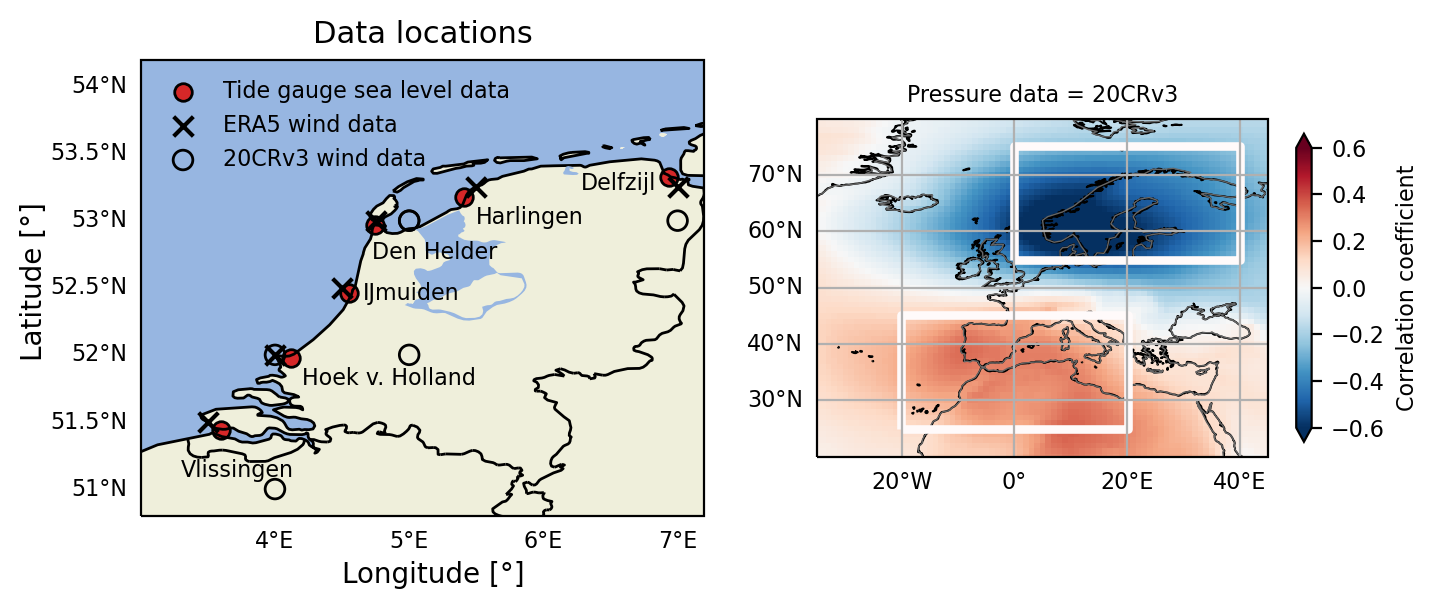

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(8,4), subplot_kw={'projection': ccrs.PlateCarree()})

fsize = 8

# Panel 1
ax[0].set_title('Data locations', fontsize = fsize+3)
ax[0].set_extent([3.0, 7.2, 50.8, 54.2], ccrs.PlateCarree())
ax[0].coastlines(resolution='10m')

# Set gridlines
gl = ax[0].gridlines(draw_labels = True, linestyle='--', alpha=0)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': fsize}
gl.ylabel_style = {'size': fsize}

# Set features
ax[0].add_feature(cf.OCEAN)
ax[0].add_feature(cf.LAND)
ax[0].add_feature(cf.LAKES)
ax[0].add_feature(cf.BORDERS)


for i, station in enumerate(tg_coords.index):
    lat = tg_coords['lat'][station]
    lon = tg_coords['lon'][station]
    ax[0].scatter(lon, lat, s=40, marker='o', color='tab:red', edgecolor = 'k', label = f'{station} ({round(lat,1)}, {round(lon,1)})')
    ax[0].scatter(era5_coords['lon'][station], era5_coords['lat'][station], s=50, marker='x', color='k')
    ax[0].scatter(twcr_coords['lon'][station], twcr_coords['lat'][station], s=50, marker='o', facecolors='none', edgecolors='k')
    
    

# Add station names
ax[0].text(tg_coords['lon']['Vlissingen']-0.3, tg_coords['lat']['Vlissingen']-0.35, 'Vlissingen', fontsize = fsize)
ax[0].text(tg_coords['lon']['Hoek van Holland']+0.08, tg_coords['lat']['Hoek van Holland']-0.2, 'Hoek v. Holland', fontsize = fsize)
ax[0].text(tg_coords['lon']['Den Helder']-0.02, tg_coords['lat']['Den Helder']-0.25, 'Den Helder', fontsize = fsize)
ax[0].text(tg_coords['lon']['Delfzijl']-0.65, tg_coords['lat']['Delfzijl']-0.1, 'Delfzijl', fontsize = fsize)
ax[0].text(tg_coords['lon']['Harlingen']+0.09, tg_coords['lat']['Harlingen']-0.2, 'Harlingen', fontsize = fsize)
ax[0].text(tg_coords['lon']['IJmuiden']+0.1, tg_coords['lat']['IJmuiden']-0.05, 'IJmuiden', fontsize = fsize)
    
    

# Add axes labels
ax[0].text(4.5, 50.3, 'Longitude [°]', fontsize = fsize + 2)
ax[0].text(2.1, 52, 'Latitude [°]', fontsize = fsize + 2, rotation='vertical')


# Add legend
ax[0].legend(labels = ['Tide gauge sea level data', 'ERA5 wind data', '20CRv3 wind data'], 
             loc='upper left', fontsize = fsize, fancybox=True, frameon = False)



# Panel 2


# Select proxy region
dang_coords_np = np.array([[-0.1, 54.9], [40.1, 54.9], [40.1, 75.1], [-0.1, 75.1]])
dang_coords_pp = np.array([[-20.1, 24.9], [20.1, 24.9], [20.1, 45.1], [-20.1, 45.1]])

dang_regions = regionmask.Regions([dang_coords_np, dang_coords_pp], numbers = [1,2], 
                                          names=["", ""], abbrevs=["NP", "PP"], 
                                          name="Dangendorf regions")


ax[1].set_extent([-35, 45, 20, 80], crs=ccrs.PlateCarree())
plot = twcr_corr.sel(station = 'Average').plot(ax=ax[1], transform = ccrs.PlateCarree(), vmin = -0.6, vmax = 0.6, 
                                              cmap = 'RdBu_r', add_colorbar=False)

cb = plt.colorbar(plot, orientation="vertical", shrink = 0.5, extend = 'both')                                   
cb.set_label(label='Correlation coefficient', size=fsize)
cb.ax.tick_params(labelsize=fsize)    
ax[1].set_title('Pressure data = 20CRv3', fontsize = fsize)
ax[1].coastlines(resolution = '50m', linewidth=.7, color = 'k')
gl = ax[1].gridlines(crs=ccrs.PlateCarree(), draw_labels = True)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': fsize}
gl.ylabel_style = {'size': fsize}
gl.ylocator = mticker.FixedLocator([30, 40, 50, 60, 70])
gl.xlocator = mticker.FixedLocator([-20, 0, 20, 40])
   

dang_regions.plot(ax = ax[1], label = 'name', line_kws = {'color':'snow', 'lw':3.1}, text_kws = dict(bbox=dict(color="none"), fontsize = fsize, color = 'snow'))


In [ ]:
def dangendorf_regions_plot(pres_corr, tg_corr, data_type):
    '''
    Function that plots a map of the North Atlantic region indicating the locations of the positive and negative correlation region
    '''
    fsize = 13
    
    
    
    # Obtain correlation
    corr = xr.corr(pres_corr, tg_corr, dim='time')
    
    corr.to_netcdf(f'./outputs/corr_{data_type}.nc')

    # Select proxy region
    dang_coords_np = np.array([[-0.1, 54.9], [40.1, 54.9], [40.1, 75.1], [-0.1, 75.1]])
    dang_coords_pp = np.array([[-20.1, 24.9], [20.1, 24.9], [20.1, 45.1], [-20.1, 45.1]])

    dang_regions = regionmask.Regions([dang_coords_np, dang_coords_pp], numbers = [1,2], 
                                          names=["", ""], abbrevs=["NP", "PP"], 
                                          name="Dangendorf regions")

    # Plot the map
    fig = plt.figure(figsize=(8,16))
    ax = plt.axes(projection=ccrs.Robinson())
    ax.set_extent([-35, 45, 20, 80], crs=ccrs.PlateCarree())
    #ax.axis('off')
    plot = corr.sel(station = 'Average').plot(ax=ax, transform = ccrs.PlateCarree(), vmin = -0.6, vmax = 0.6, 
                                              cmap = 'RdBu_r', add_colorbar=False)
    cb = plt.colorbar(plot, orientation="vertical", shrink = 0.35, extend = 'both')                                   
    cb.set_label(label='Correlation coefficient', size=15)
    cb.ax.tick_params(labelsize=15)    
    if data_type == 'ERA5':
        ax.set_title('Pressure data = ERA5', fontsize = 15)
    elif data_type == '20CR':
        ax.set_title('Pressure data = 20CRv3', fontsize = 15)
    ax.coastlines(resolution = '50m', linewidth=.7, color = 'k')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 15}
    gl.ylabel_style = {'size': 15}
    gl.ylocator = mticker.FixedLocator([30, 40, 50, 60, 70])
    gl.xlocator = mticker.FixedLocator([-20, 0, 20, 40])
    
    
    # Add axes labels
    #plt.text(-10, 10, 'Longitude [°]', fontsize = 15)
    #plt.text(-30, 40, 'Latitude [°]', fontsize = 15, rotation='vertical')
    
    
    dang_regions.plot(ax = ax, label = 'name', line_kws = {'color':'snow', 'lw':3.1}, text_kws = dict(bbox=dict(color="none"), fontsize = 15, color = 'snow'))

    
    plt.savefig(f'./figures/corr_map_{data_type}', bbox_inches='tight', dpi = 150)
    
   

## Fig. 2: sea level time series

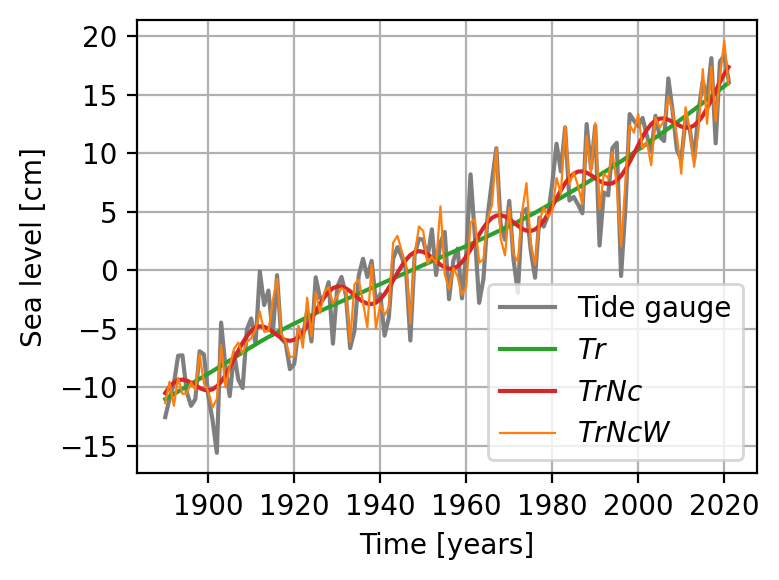

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(4,3)) #14,5

panels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

colors = ['tab:green', 'tab:red', 'tab:orange', 'tab:blue']

tg_df['Average'].plot(label='Tide gauge', color='tab:grey')
res_nr.total.plot(label=short_names[0], color=colors[0])
res_nt.total.plot(label=short_names[1], color=colors[1])
res_na.total.plot(label=short_names[2], color=colors[2], linewidth=0.8)

ax.set_ylabel('Sea level [cm]')
# ax.grid(True)
ax.set_xticks(np.arange(1900,2021,20))
ax.grid(axis='x', which='major')
ax.grid(axis='y', which='major')
ax.set_xlabel('Time [years]')
#ax.text(0.01, 0.92, panels[idx], transform=ax.flat[idx].transAxes, size=14)

ax.legend(loc='lower right')

    
fig.tight_layout()

plt.savefig(f'./figures/{region}/TideGauge_StatModels.pdf', dpi=150)

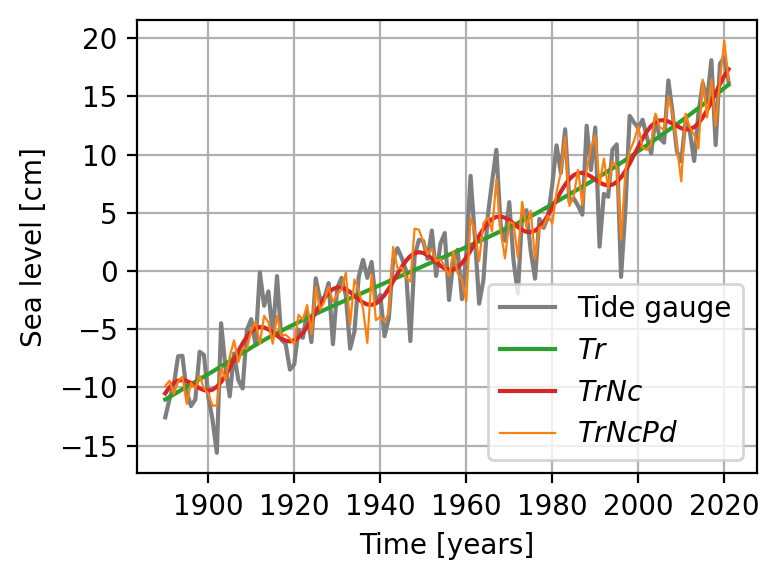

In [150]:
fig, ax = plt.subplots(1, 1, figsize=(4,3)) #14,5

panels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

colors = ['tab:green', 'tab:red', 'tab:orange', 'tab:blue']

tg_df['Average'].plot(label='Tide gauge', color='tab:grey')
res_nr.total.plot(label=short_names[0], color=colors[0])
res_nt.total.plot(label=short_names[1], color=colors[1])
res_pd.total.plot(label=short_names[3], color=colors[2], linewidth=0.8)

ax.set_ylabel('Sea level [cm]')
# ax.grid(True)
ax.set_xticks(np.arange(1900,2021,20))
ax.grid(axis='x', which='major')
ax.grid(axis='y', which='major')
ax.set_xlabel('Time [years]')
#ax.text(0.01, 0.92, panels[idx], transform=ax.flat[idx].transAxes, size=14)

ax.legend(loc='lower right')

    
fig.tight_layout()

plt.savefig(f'./figures/{region}/TideGauge_StatModels.pdf', dpi=150)

## Fig. 3: Wind contribution to sea level

In [151]:
wind_rec = pd.read_csv(f'{output_dir}/WindInfluence.csv')
wind_rec.set_index('time', inplace=True)

In [152]:
# Estimate the linear trend for different periods

mid_point = int(len(wind_rec.index)/2)
print(mid_point)

lin_trend_na1 = round(linregress(wind_rec.index[0:mid_point], 
                                 wind_rec['NearestPointAverage2_trend'].iloc[0:mid_point]).slope*10, 2)
lin_trend_na2 = round(linregress(wind_rec.index[mid_point:-1], 
                                 wind_rec['NearestPointAverage2_trend'].iloc[mid_point:-1]).slope*10, 2)

lin_trend_pd1 = round(linregress(wind_rec.index[0:mid_point], 
                                 wind_rec['PressureDifference_trend'].iloc[0:mid_point]).slope*10, 2)
lin_trend_pd2 = round(linregress(wind_rec.index[mid_point:-1], 
                                 wind_rec['PressureDifference_trend'].iloc[mid_point:-1]).slope*10, 2)

93


/var/folders/sg/bjgd139d48v526p07tp867mh0000gn/T/ipykernel_18059/2806707184.py:49: RuntimeWarning: divide by zero encountered in divide
  xf_p = 1/xf_mtm


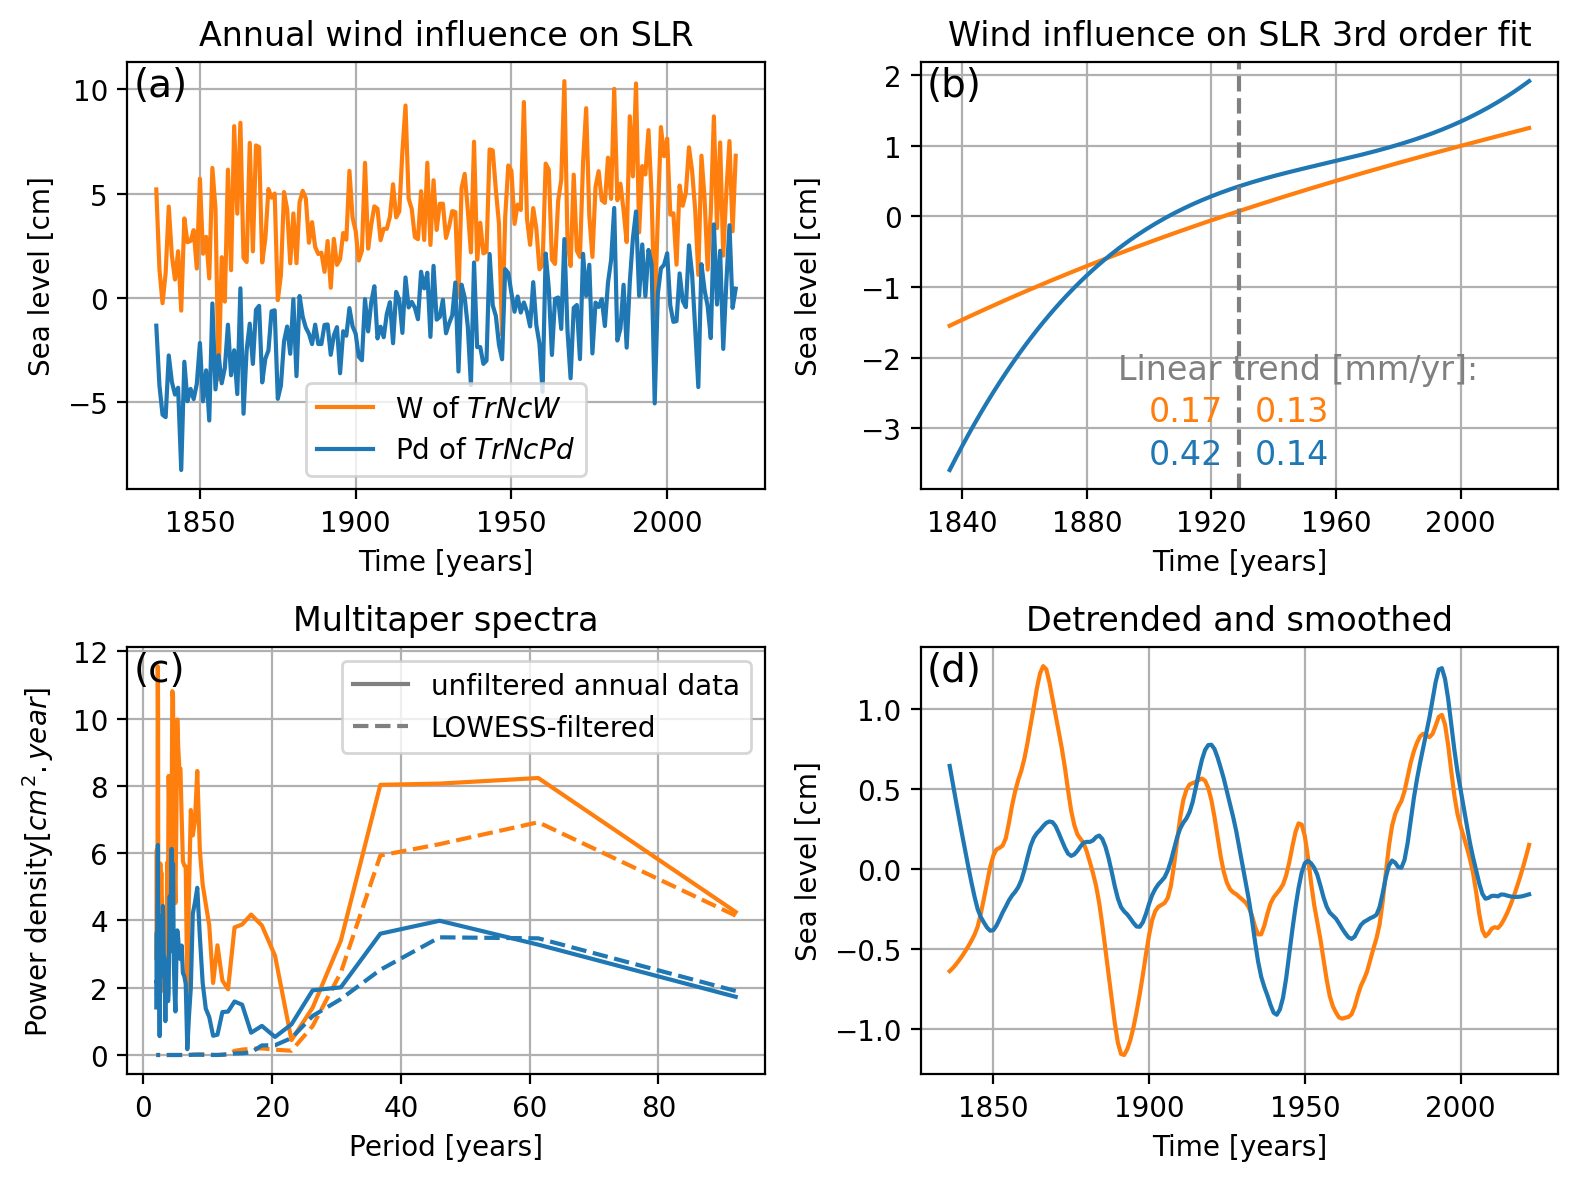

In [153]:
fig, ax = plt.subplots(2, 2, figsize=(8,6)) #14, 10

colors = ['tab:green', 'tab:red', 'tab:orange', 'tab:blue']


# Panel 1
wind_rec[['NearestPointAverage2', 'PressureDifference']].plot(ax=ax[0,0], color=[colors[2], colors[3]])

ax[0,0].legend(['W of $\it{TrNcW}$', 'Pd of $\it{TrNcPd}$'])
ax[0,0].set_title('Annual wind influence on SLR')
ax[0,0].set_ylabel('Sea level [cm]')
ax[0,0].set_xlabel('Time [years]')


# Panel 2
(wind_rec['NearestPointAverage2_trend']-wind_rec['NearestPointAverage2_trend'].mean() ).plot(ax=ax[0,1], color=colors[2])
(wind_rec['PressureDifference_trend']-wind_rec['PressureDifference_trend'].mean() ).plot(ax=ax[0,1], color=colors[3])                                                                                                          

ax[0,1].text(1900, -2.9, lin_trend_na1, size=12, color=colors[2])
ax[0,1].text(1934, -2.9, lin_trend_na2, size=12, color=colors[2])

ax[0,1].text(1900, -3.5, lin_trend_pd1, size=12, color=colors[3])
ax[0,1].text(1934, -3.5, lin_trend_pd2, size=12, color=colors[3])

ax[0,1].text(1890, -2.3, 'Linear trend [mm/yr]:', size=12, color='grey')

ax[0,1].axvline(x=wind_rec.index[mid_point], color='grey', linestyle='--')

ax[0,1].set_title('Wind influence on SLR 3rd order fit')
ax[0,1].set_ylabel('Sea level [cm]')
ax[0,1].set_xlabel('Time [years]')


ax[0,1].set_xticks(range(1840, 2020, 40))

'''
list_st = [1840, 1860, 1880, 1900, 1920, 1940, 1960, 1980, 2000]
for st in list_st:
    avg_rate = round(res.loc[st:st+19,'0.5'].mean(axis=0),1)
    ax[0,1].text(st+3, 0.55, avg_rate, size=12, color='grey')
    ax[0,1].vlines(x=st, ymin=0.75, ymax=0.95, color='grey', linestyle='-')
ax[0,1].vlines(x=st+19, ymin=0.75, ymax=0.95, color='grey', linestyle='-')
'''

# Panel 3
xf_mtm, yf_mtm, _ = loc.mtm(wind_rec['NearestPointAverage2_dt'].values, 1)

# Change x-axis from frequency to period
xf_p = 1/xf_mtm
ax[1,0].plot(xf_p[2:], yf_mtm[2:], label='NPA', color=colors[2])

xf_mtm, yf_mtm, _ = loc.mtm(wind_rec['NearestPointAverage2_lowess'].values, 1)
ax[1,0].plot(xf_p[2:], yf_mtm[2:], label='NPA', color=colors[2], linestyle = 'dashed')

xf_mtm, yf_mtm, _ = loc.mtm(wind_rec['PressureDifference_dt'].values, 1)
ax[1,0].plot(xf_p[2:], yf_mtm[2:], label='PD', color=colors[3])

xf_mtm, yf_mtm, _ = loc.mtm(wind_rec['PressureDifference_lowess'].values, 1)
ax[1,0].plot(xf_p[2:], yf_mtm[2:], label='PD', color=colors[3], linestyle = 'dashed')

l1, = ax[1,0].plot([],[], c='grey', label='unfiltered annual data')
l2, = ax[1,0].plot([],[], c='grey', ls='--', label='LOWESS-filtered')
ax[1,0].legend(handles=[l1,l2])

ax[1,0].set_title('Multitaper spectra')
ax[1,0].set_ylabel('Power density'+r'$[cm^2.year]$')
ax[1,0].set_xlabel('Period [years]')

# Panel 4
wind_rec[['NearestPointAverage2_lowess', 'PressureDifference_lowess']].plot(ax=ax[1,1], color=[colors[2], colors[3]])

ax[1,1].set_title('Detrended and smoothed')
ax[1,1].set_xlabel('Time [years]')
ax[1,1].set_ylabel('Sea level [cm]')

ax[1,1].get_legend().remove()

for idx in range(4):
    ax.flat[idx].text(0.01, 0.92, panels[idx], 
                      transform=ax.flat[idx].transAxes, size=14)
    ax.flat[idx].grid(True)

fig.tight_layout()
fig.align_ylabels()

plt.savefig(f'./figures/{region}/WindInfluenceComp_lowess21.pdf', dpi=150)

## Fig. 4: Rate of sea level rise

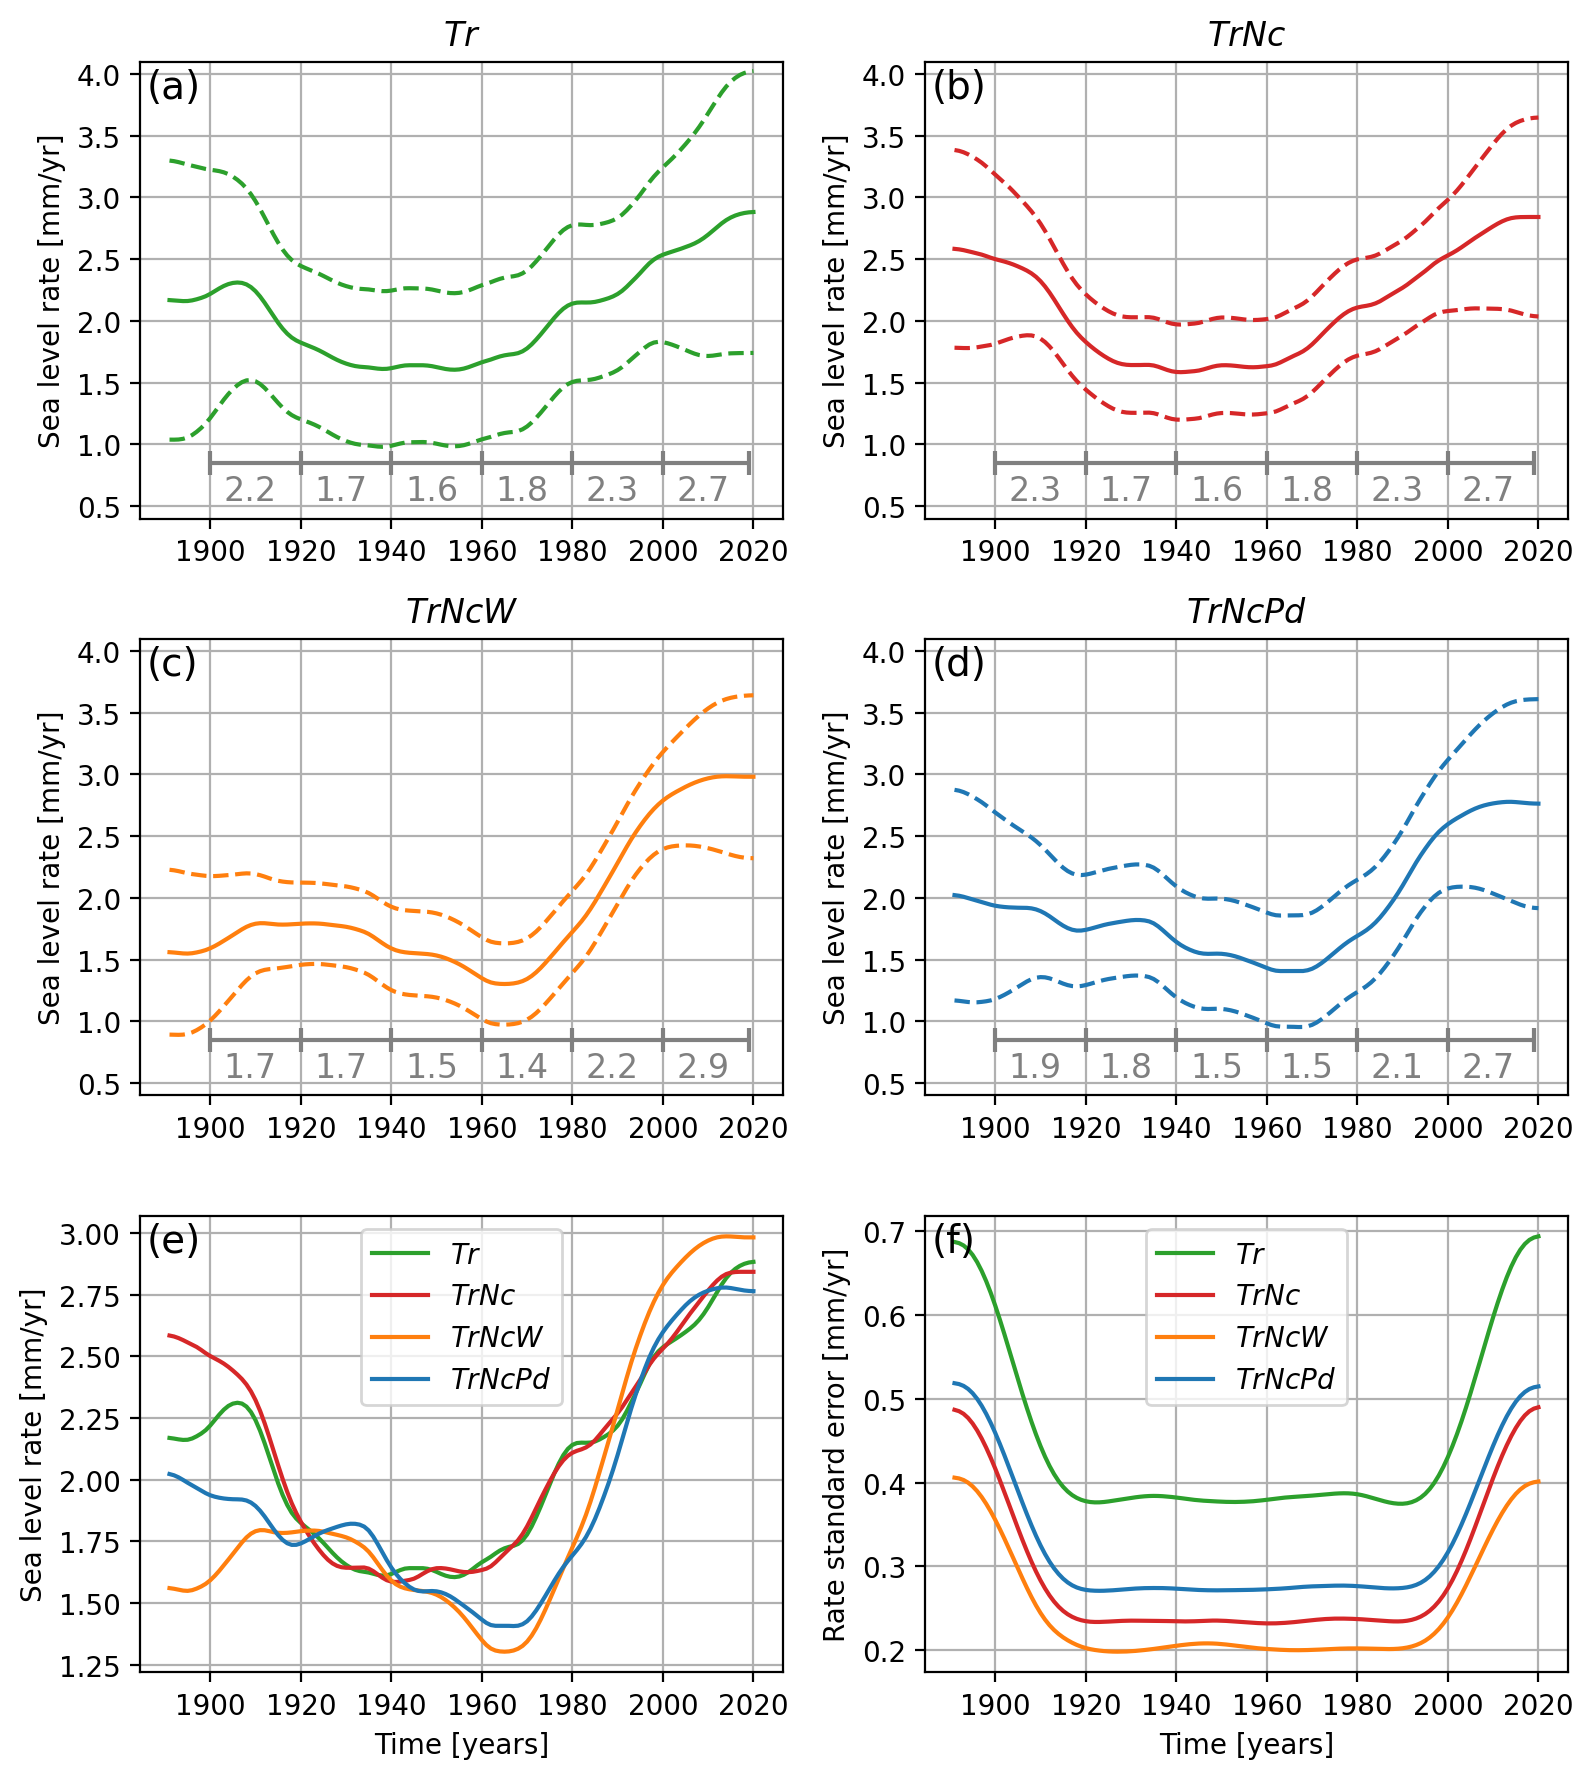

In [154]:
list_st = [1900, 1920, 1940, 1960, 1980, 2000]

fig, ax = plt.subplots(3, 2, figsize=(8,9))

for idx, res in enumerate([rates_q_nr, rates_q_nt, rates_q_na, rates_q_pd]):
    
    res['0.5'].plot(ax=ax.flat[idx], title=short_names[idx], color=colors[idx])
    res['0.05'].plot(ax=ax.flat[idx], linestyle='dashed', 
                                          color=colors[idx])
    res['0.95'].plot(ax=ax.flat[idx], linestyle='dashed', 
                                          color=colors[idx])
    
    ax.flat[idx].set_xlabel('')
    ax.flat[idx].set_ylabel('Sea level rate [mm/yr]')
    ax.flat[idx].set_ylim([0.4, 4.1])
    # ax.flat[idx].grid(True)
    ax.flat[idx].text(0.01, 0.92, panels[idx], transform=ax.flat[idx].transAxes, 
                      size=14)
    
    ax.flat[idx].hlines(y=0.85, xmin=list_st[0], xmax=list_st[5]+19, 
                        color='grey', linestyle='-')
    #ax.flat[idx].hlines(y=0.85, xmin=list_st[5], xmax=list_st[5]+19, 
    #                    color='grey', linestyle='-')
    
    for st in list_st:
        avg_rate = round(res.loc[st:st+19,'0.5'].mean(axis=0),1)
        ax.flat[idx].text(st+3, 0.55, avg_rate, size=12, color='grey')
        ax.flat[idx].vlines(x=st, ymin=0.75, ymax=0.95, color='grey', 
                            linestyle='-')
    ax.flat[idx].vlines(x=st+19, ymin=0.75, ymax=0.95, color='grey', linestyle='-')

rates_q_nr['0.5'].plot(ax=ax.flat[4], color=colors[0], label=short_names[0])
rates_q_nt['0.5'].plot(ax=ax.flat[4], color=colors[1], label=short_names[1])
rates_q_na['0.5'].plot(ax=ax.flat[4], color=colors[2], label=short_names[2])
rates_q_pd['0.5'].plot(ax=ax.flat[4], color=colors[3], label=short_names[3])

ax.flat[4].set_ylabel('Sea level rate [mm/yr]')
ax.flat[4].set_xlabel('Time [years]')
ax.flat[4].legend()
# ax.flat[4].grid(True)
ax.flat[4].text(0.01, 0.92, panels[4], transform=ax.flat[4].transAxes, size=14)

ser_nr.plot(ax=ax.flat[5], color=colors[0], label=short_names[0])
ser_nt.plot(ax=ax.flat[5], color=colors[1], label=short_names[1])
ser_na.plot(ax=ax.flat[5], color=colors[2], label=short_names[2])
ser_pd.plot(ax=ax.flat[5], color=colors[3], label=short_names[3])

ax.flat[5].set_ylabel('Rate standard error [mm/yr]')
ax.flat[5].set_xlabel('Time [years]')
ax.flat[5].legend()
# ax.flat[5].grid(True)
ax.flat[5].text(0.01, 0.92, panels[5], transform=ax.flat[5].transAxes, size=14)

for i in range(3):
    for j in range(2):
        ax[i,j].set_xticks(np.arange(1900,2021,20))
        ax[i,j].grid(axis='x', which='major')
        ax[i,j].grid(axis='y', which='major')

fig.tight_layout()
plt.savefig(f'./figures/{region}/{bootsize}/RateSeaLevelTrend.pdf', dpi=150)

## Fig. A1: Nodal effects on sea level

/var/folders/sg/bjgd139d48v526p07tp867mh0000gn/T/ipykernel_18059/204780453.py:21: RuntimeWarning: divide by zero encountered in divide
  xf_p = 1/xf_mtm


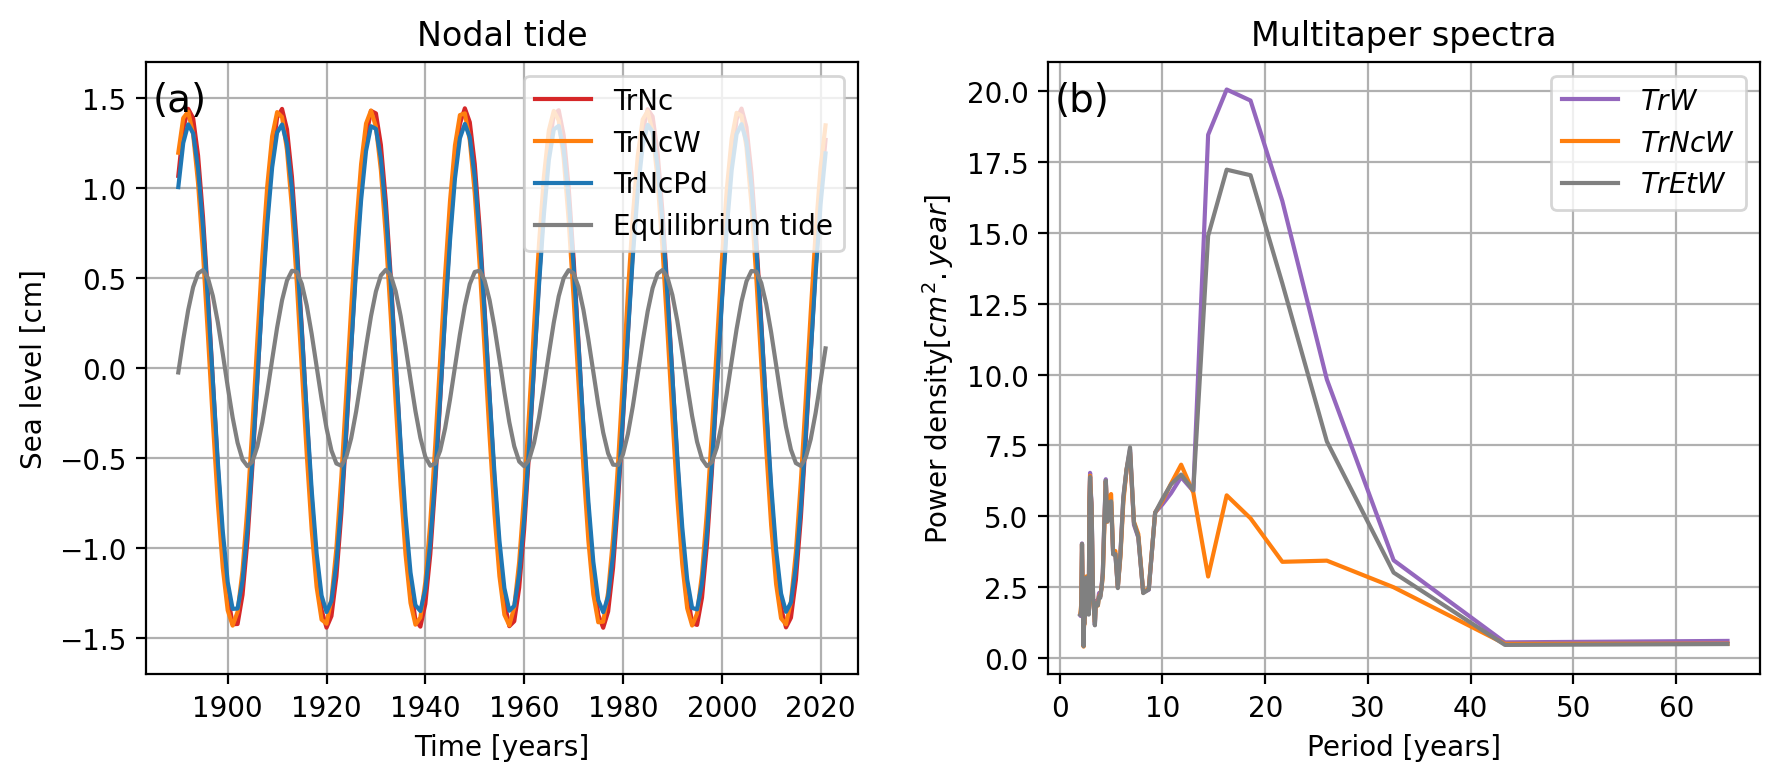

In [155]:
colors = ['tab:red', 'tab:orange', 'tab:blue', 'grey', 'tab:purple']


fig, ax = plt.subplots(1, 2, figsize=(9,4)) #14, 10

# Panel 1
for idx, data in enumerate(nodal):
    ax[0].plot(nodal.index, nodal[data], label=data, color=colors[idx])

ax[0].set_xlabel('Time [years]')
ax[0].set_ylabel('Sea level [cm]')
ax[0].set_title('Nodal tide')
ax[0].legend(loc='upper right')
ax[0].set_ylim(-1.7,1.7)

# Panel 2

xf_mtm, yf_mtm, _ = loc.mtm(nodal_residuals['NearestPointAverageNoTide_dt'].values, 1)

# Change x-axis from frequency to period
xf_p = 1/xf_mtm

ax[1].plot(xf_p[2:], yf_mtm[2:], label='$\it{TrW}$', color=colors[4])

xf_mtm, yf_mtm, _ = loc.mtm(nodal_residuals['NearestPointAverage2_dt'].values, 1)
ax[1].plot(xf_p[2:], yf_mtm[2:], label='$\it{TrNcW}$', color=colors[1])

xf_mtm, yf_mtm, _ = loc.mtm(nodal_residuals['EquilibriumTide_dt'].values, 1)
ax[1].plot(xf_p[2:], yf_mtm[2:], label='$\it{TrEtW}$', color=colors[3])




ax[1].legend()
ax[1].set_title('Multitaper spectra')
ax[1].set_ylabel('Power density'+r'$[cm^2.year]$')
ax[1].set_xlabel('Period [years]')

for idx in range(2):
    ax.flat[idx].text(0.01, 0.92, panels[idx], 
                      transform=ax.flat[idx].transAxes, size=14)
    ax.flat[idx].grid(True)

fig.tight_layout()

plt.savefig(f'./figures/{region}/NodalTide.pdf', dpi=150)

## Fig. A2: Rates of SLR of individual tide gauges

In [156]:
stations = ['Vlissingen', 'Hoek van Holland', 'Den Helder', 'Delfzijl', 'Harlingen', 'IJmuiden']
bootsize = 10000 # Choose from 100, 1000, 10000
model = 'NearestPointAverage2'

In [157]:
rates_q_tgstations = []
ser_tgstations = []

for station in stations:
    output_dir = f'./outputs/{station}/{bootsize}'
    rates_q_tgstations.append(pd.read_csv(f'{output_dir}/rates_quantiles_{model}.csv', index_col = 'time'))
    rates_tgstations = pd.read_csv(f'{output_dir}/rates_{model}.csv', index_col = 'time')
    ser_tgstations.append(rates_tgstations.std(axis=1))

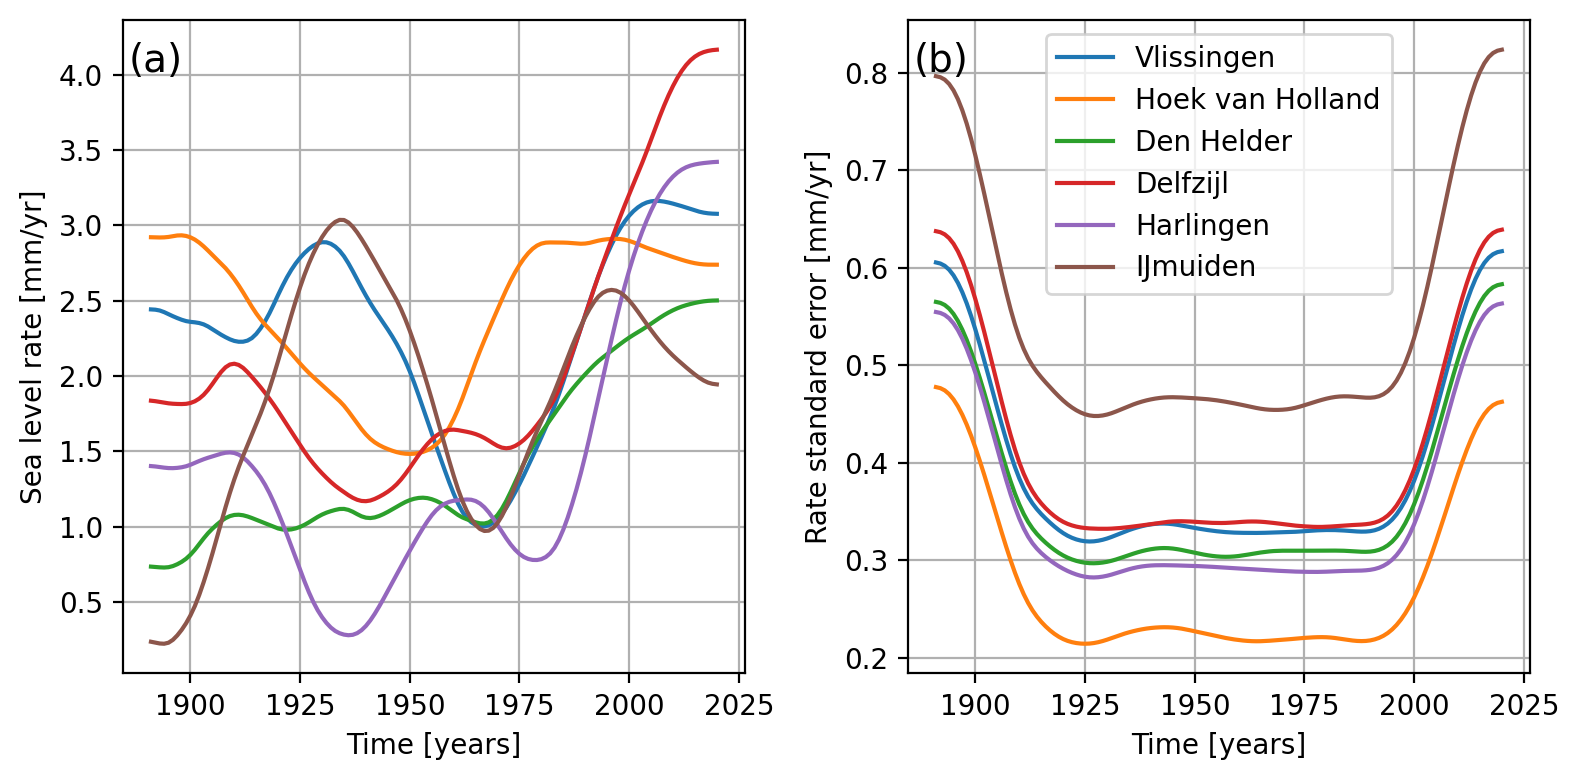

In [158]:
list_st = [1900, 1920, 1940, 1960, 1980, 2000]

fig, axs = plt.subplots(1, 2, figsize=(8,4))

# Panel 1
for idx, station in enumerate(stations):
    
    axs[0].plot(rates_q_tgstations[idx].index, rates_q_tgstations[idx]['0.5'], label = station)

    
axs[0].set_xlabel('Time [years]')
axs[0].set_ylabel('Sea level rate [mm/yr]')
axs[0].grid()
axs[0].text(0.01, 0.92, panels[0], transform=axs[0].transAxes, size=14)


# Panel 2
for idx, station in enumerate(stations):
    
    axs[1].plot(ser_tgstations[idx].index, ser_tgstations[idx].values, label = station)


axs[1].set_xlabel('Time [years]')
axs[1].set_ylabel('Rate standard error [mm/yr]')
axs[1].legend()
axs[1].grid()
axs[1].text(0.01, 0.92, panels[1], transform=axs[1].transAxes, size=14)



fig.tight_layout()
plt.savefig(f'./figures/RateSeaLevelTrendStations_{model}_{bootsize}.pdf', dpi=150)

In [159]:
string = 'Mean uncertainty per station:\n'
for idx, station in enumerate(stations):
    string += f'{station}: {round(ser_tgstations[idx].mean(),2)}\n'
    
print(string)

Mean uncertainty per station:
Vlissingen: 0.39
Hoek van Holland: 0.28
Den Helder: 0.37
Delfzijl: 0.4
Harlingen: 0.35
IJmuiden: 0.54



## Fig. A3: Low-frequency wind influence on sea level

This figure is created in the notebook sst.ipynb

In [138]:
def regression_regions_fig(data_results, var, var_label, wind_model, title, ticks, cmap, extend, name):
    '''
    Function to make a plot of the three regions used for the lagged regression. '''
    
    amv = np.array([[-80, 0], [-80, 60], [0, 60], [0, 0]])
    north = np.array([[-40, 55], [-40, 65], [10, 65], [10, 55]])
    south = np.array([[-80, 10], [-80, 22], [-30, 22], [-30, 10]])
    
    fsize = 11

    
    plt.figure(figsize = (7,7))
    
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=-45))
    ax.coastlines()
    plot = data_results[var].sel(wind_model = wind_model).plot(ax=ax, transform=ccrs.PlateCarree(), vmax = 0.7, cmap = cmap, 
                                                        add_colorbar=False)
    
    cb = plt.colorbar(plot, orientation="vertical", fraction = 0.035, ticks=ticks, extend=extend)                                   
    cb.set_label(label=var_label, size=fsize+2)
    cb.ax.tick_params(labelsize=fsize)                      
    
    ax.set_title(title, fontsize = fsize)
    ax.add_feature(cf.LAND, color='silver', alpha = 0.25)
    #ax.add_feature(cf.OCEAN, color='silver', alpha = 0.5)
    ax.coastlines(resolution = '50m', linewidth=.7, color = 'k')
    ax.set_extent([-100, 10, 0, 80], crs=ccrs.PlateCarree())
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': fsize}
    gl.ylabel_style = {'size': fsize}
    gl.ylocator = mticker.FixedLocator([20, 40, 60])
    gl.xlocator = mticker.FixedLocator([-80, -40, 0])
    
    text_kws = dict(bbox=dict(color="none"), fontsize=fsize + 4, color = 'k')
    line_kws = dict(color = 'k', lw = 3)
    regionmask.Regions([amv], names=["AMV"]).plot(ax = ax, resolution="50m", 
                                                                                  projection=ccrs.Robinson(), 
                                                                                  label='name', 
                                                                                  line_kws=line_kws,
                                                                                  text_kws=text_kws)
    text_kws = dict(bbox=dict(color="none"), fontsize=fsize + 4, color = 'white')
    line_kws = dict(color = 'white', lw = 3)
    regionmask.Regions([north, south], names=["North", "South"]).plot(ax = ax, resolution="50m", 
                                                                                  projection=ccrs.Robinson(), 
                                                                                  label='name', 
                                                                                  line_kws=line_kws,
                                                                                  text_kws=text_kws)
    
    
    
    


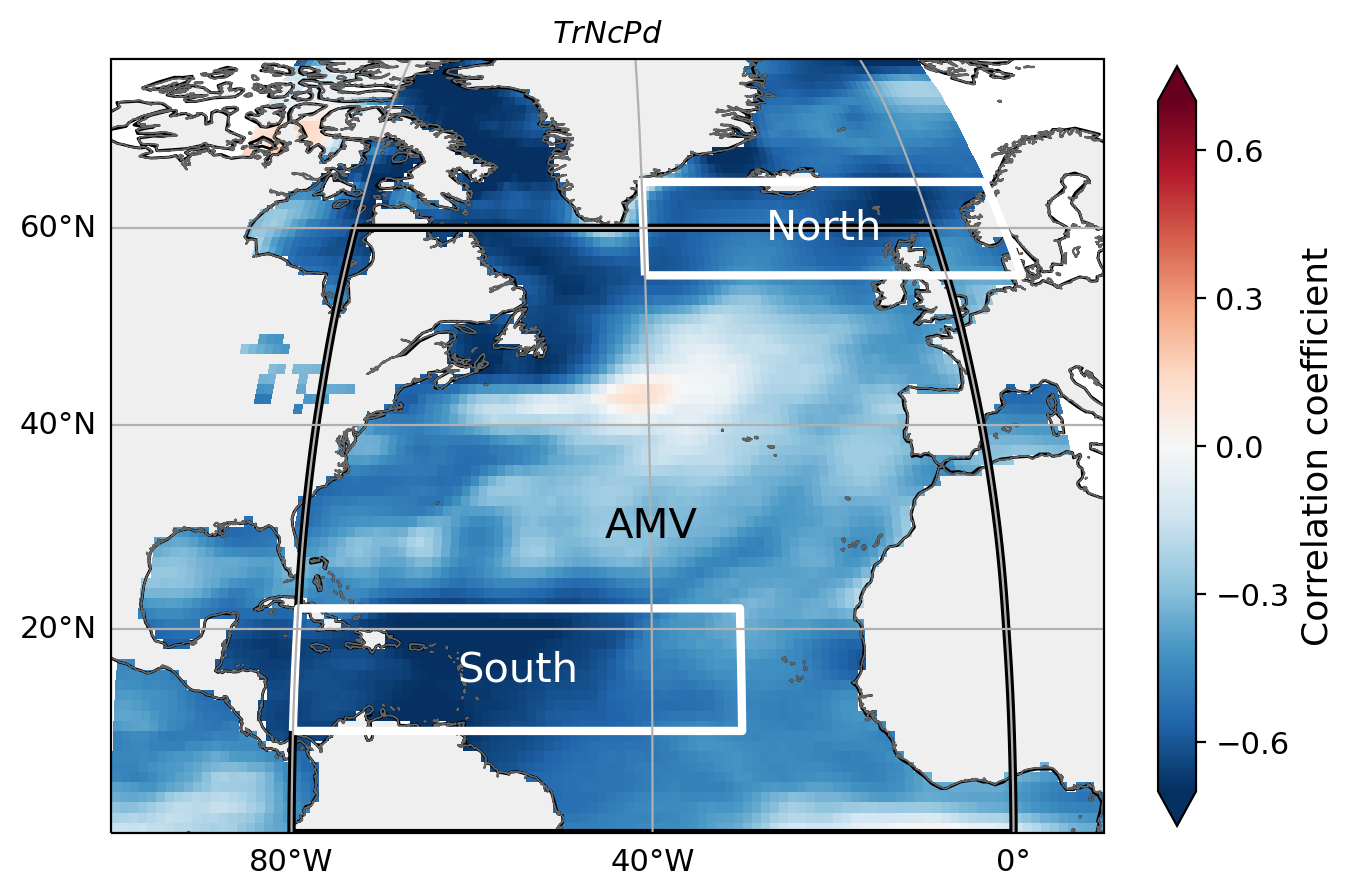

In [139]:
regression_regions_fig(cobe_sst, 'r', 'Correlation coefficient', 'PressureDifference', '$\it{TrNcPd}$', 
                       [-0.6, -0.3, 0.0, 0.3, 0.6], 'RdBu_r', 'both', 'cobesst_r_PD')

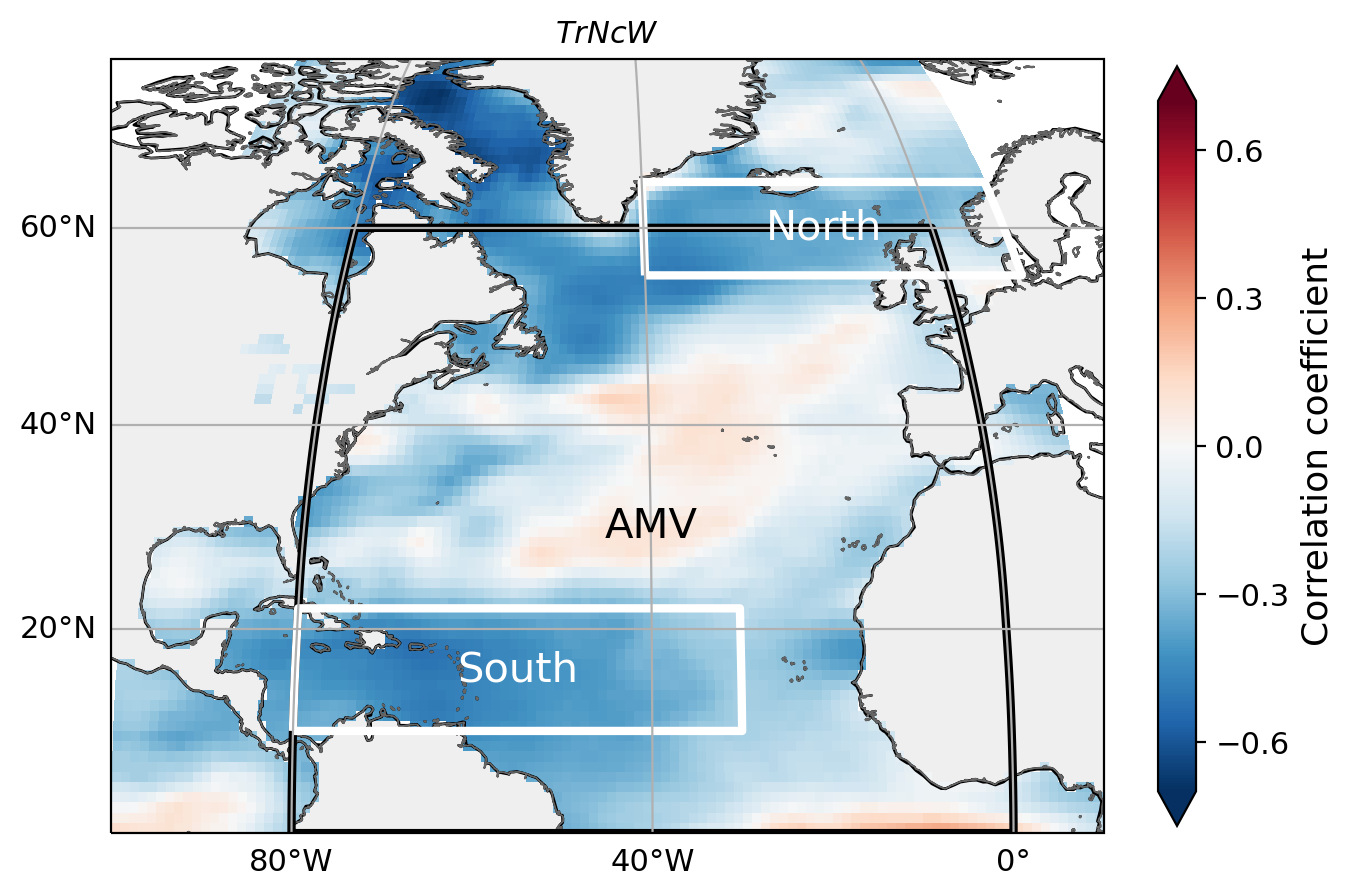

In [141]:
regression_regions_fig(cobe_sst, 'r', 'Correlation coefficient', 'NearestPointAverage2', '$\it{TrNcW}$', 
                       [-0.6, -0.3, 0.0, 0.3, 0.6], 'RdBu_r', 'both', 'cobesst_r_NP')

In [72]:
def compare_reg_res_fig_cobe(var, var_label, ymin = 0.0, ymax = 0.8):
    '''
    Function that plots a figure to compare the results of the regression for the different regions.'''
    
    labels_wind = ['NearestPointAverage2', 'PressureDifference']
    labels_AMV = ['HadISSTv1.1', 'COBE-SST2']
    colors = ['tab:red', 'tab:orange', 'tab:blue']
    
    s = 20
    
    fig, axs = plt.subplots(2, 1, figsize = (7,8))

    for i, l in enumerate(labels_wind):


        ax = axs[i]

        data_amv = results_amv.swaplevel(0,1, axis=1)[l]
        data_north = results_north.swaplevel(0,1, axis=1)[l]
        data_south = results_south.swaplevel(0,1, axis=1)[l]

        dataT_amv = data_amv[labels_AMV[1]].T
        dataT_north = data_north[labels_AMV[1]].T
        dataT_south = data_south[labels_AMV[1]].T

        ax.scatter(dataT_amv.index, dataT_amv[var].values, s = s, color = colors[0])
        ax.scatter(dataT_north.index, dataT_north[var].values, s = s, color = colors[1])
        ax.scatter(dataT_south.index, dataT_south[var].values, s = s, color = colors[2])
        ax.grid() 
        
        error_amv = (1-dataT_amv[var].values**2 ) / (np.sqrt(dataT_amv[var].size-2))
        error_north = (1-dataT_north[var].values**2 ) / (np.sqrt(dataT_north[var].size-2))
        error_south = (1-dataT_south[var].values**2 ) / (np.sqrt(dataT_south[var].size-2))
        
        df = pd.DataFrame({'lag': dataT_amv.index, 'AMV_r': dataT_amv[var].values, 'North_r': dataT_north[var].values, 'South_r': dataT_south[var].values,
                          'AMV_stderr': error_amv, 'North_stderr': error_north, 'South_stderr': error_south}).set_index('lag')
        
        df.to_csv(f'./outputs/cobe_lagged_corr_{l}.csv')
        
        ax.fill_between(dataT_amv.index.astype('float'), dataT_amv[var].values.astype('float') - error_amv, dataT_amv[var].values.astype('float') + error_amv, alpha = 0.2, color = colors[0])
        ax.fill_between(dataT_north.index.astype('float'), dataT_north[var].values.astype('float') - error_north, dataT_north[var].values.astype('float') + error_north, alpha = 0.2, color = colors[1])
        ax.fill_between(dataT_south.index.astype('float'), dataT_south[var].values.astype('float') - error_south, dataT_south[var].values.astype('float') + error_south, alpha = 0.2, color = colors[2])
        
        ax.set_ylabel(f'{var_label}', fontsize=17)   
        ax.set_xticks([-40, -20, 0, 20, 40])
        ax.set_yticks([-0.8, -0.4, 0.0, 0.4, 0.8])
        ax.tick_params(axis='both', which='major', labelsize=15)
        
        
        if i == 1:
            ax.set_xlabel('Lag [years]', fontsize=17)
            ax.legend(labels = ['AMV', 'North', 'South'],loc = 'lower left', fontsize =  15)
            
        setups = ['$\it{TrNcW}$', '$\it{TrNcPd}$']
        ax.set_title(f'\n{setups[i]}', fontsize=15)
            
        ax.set_ylim(ymin, ymax) 
        

    plt.tight_layout()
    plt.savefig('./figures/cobe_lagged_correlation_sst.pdf', dpi = 150)



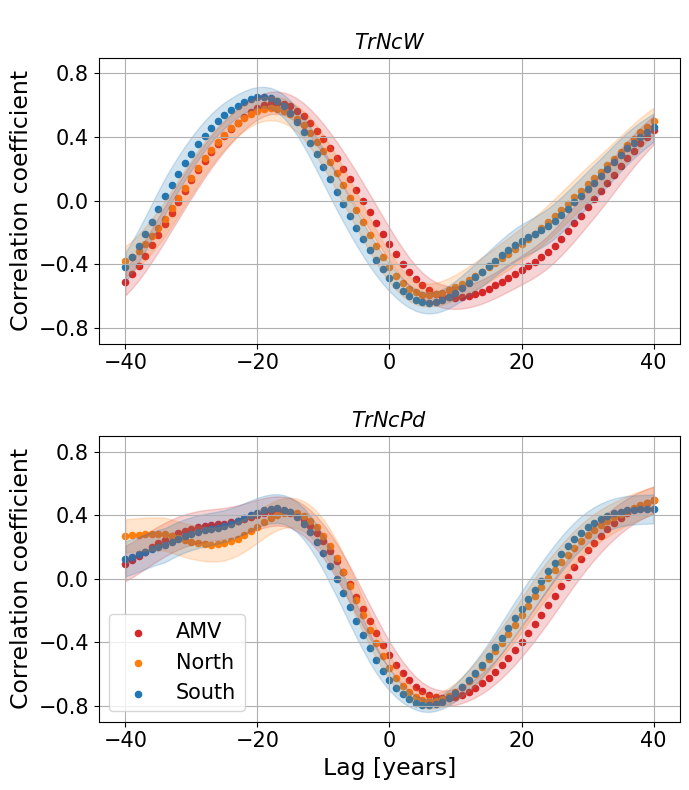

In [73]:
compare_reg_res_fig_cobe('r', 'Correlation coefficient', ymin = -0.9, ymax = 0.9)


In [ ]:
cobe_lagged_na = pd.read_csv(f'{output_dir}cobe_lagged_corr_NearestPointAverage2.csv', index_col = 'lag')
cobe_lagged_pd = pd.read_csv(f'{output_dir}cobe_lagged_corr_PressureDifference.csv', index_col = 'lag')

In [143]:
cobe_lagged_na

,AMV_r,North_r,South_r,AMV_stderr,North_stderr,South_stderr
lag,,,,,,
-40,-0.514439,-0.382952,-0.419209,0.082734,0.096009,0.092737
-39,-0.465681,-0.352809,-0.357012,0.088110,0.098504,0.098169
-38,-0.409840,-0.315402,-0.287073,0.093611,0.101317,0.103237
-37,-0.348368,-0.271665,-0.211426,0.098855,0.104205,0.107480
-36,-0.282834,-0.222758,-0.132432,0.103509,0.106926,0.110536
...,...,...,...,...,...,...
36,0.265173,0.346501,0.327714,0.104598,0.099001,0.100426
37,0.314013,0.388207,0.365058,0.101415,0.095553,0.097515
38,0.359890,0.428363,0.398609,0.097937,0.091864,0.094632


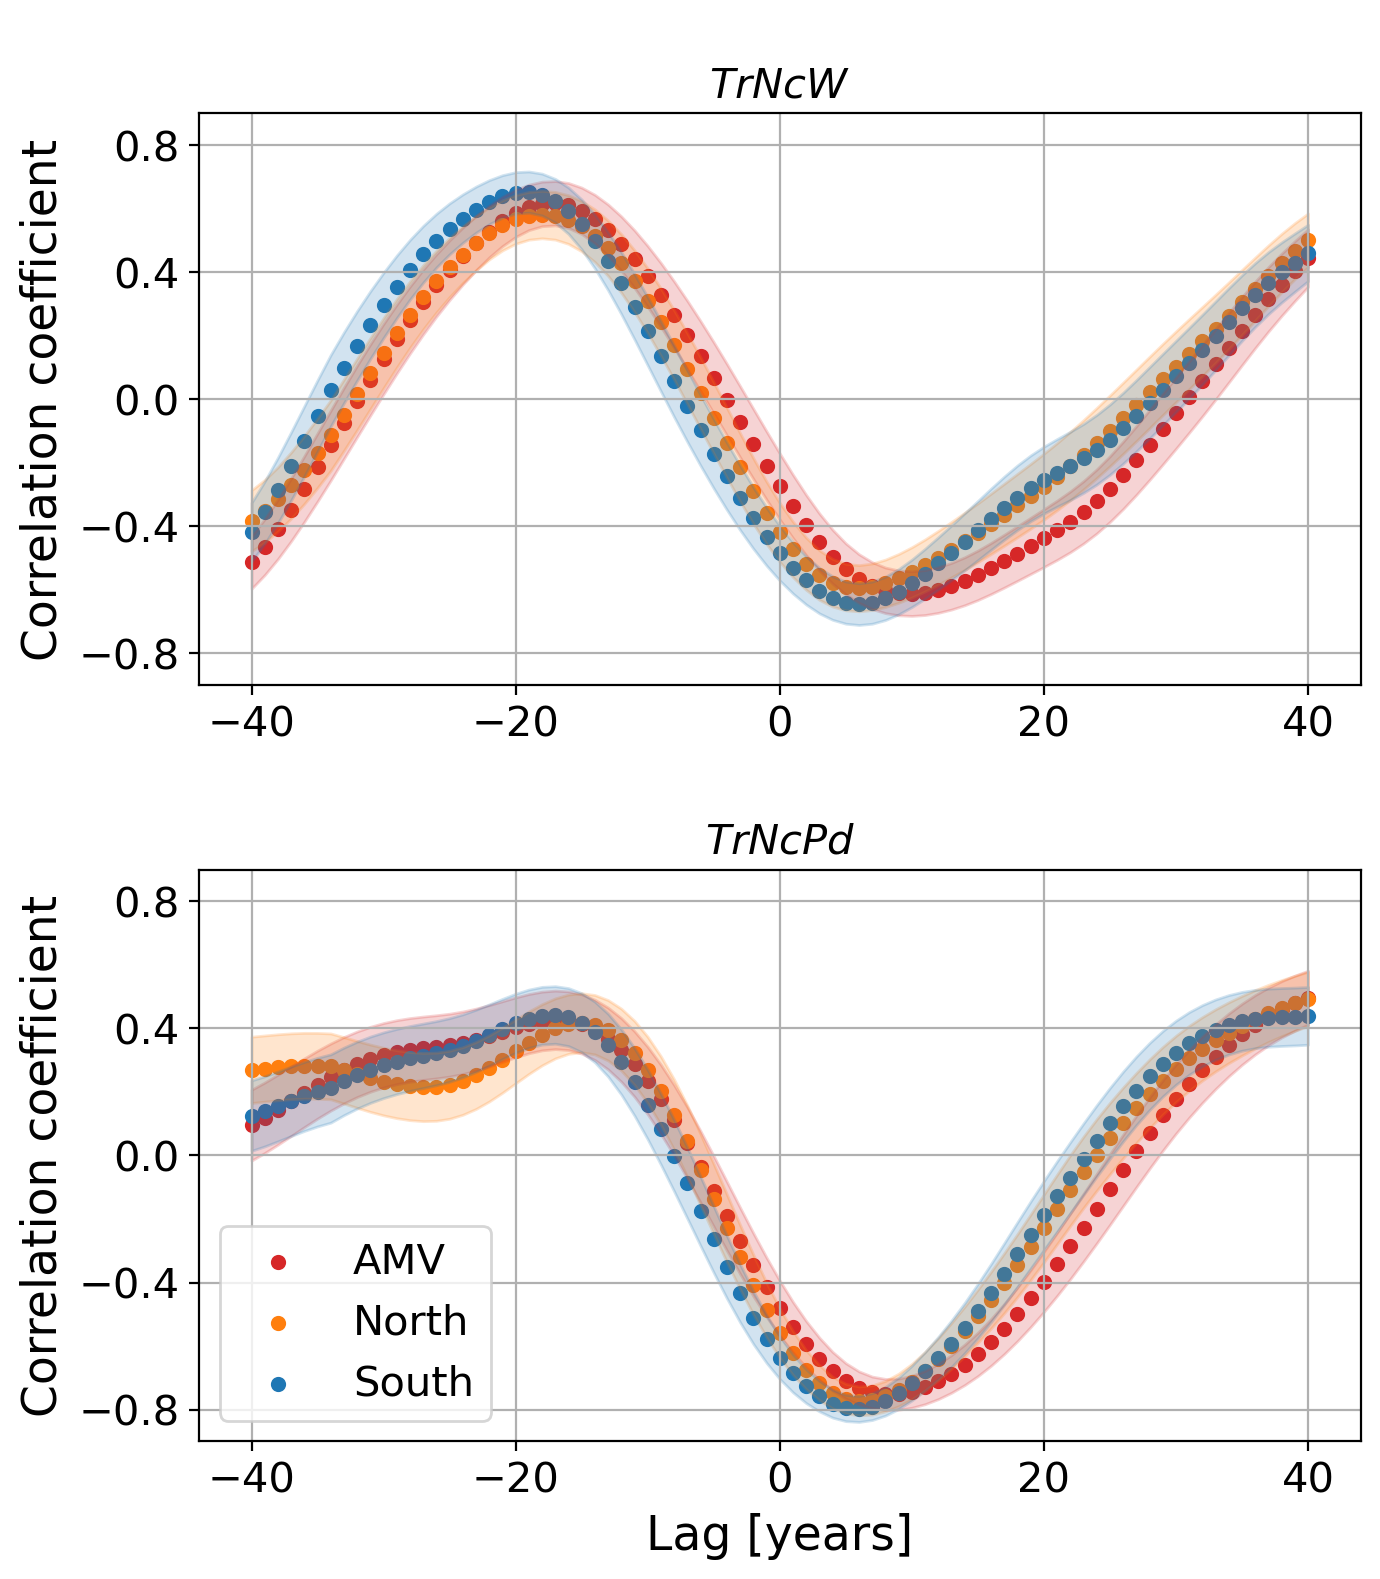

In [149]:
labels_wind = ['NearestPointAverage2', 'PressureDifference']
colors = ['tab:red', 'tab:orange', 'tab:blue']
data = [cobe_lagged_na, cobe_lagged_pd]

s = 20

fig, axs = plt.subplots(2, 1, figsize = (7,8))

for i, l in enumerate(labels_wind):


    ax = axs[i]
    
    ax.scatter(data[i].index, data[i]['AMV_r'], s = s, color = colors[0])
    ax.scatter(data[i].index, data[i]['North_r'], s = s, color = colors[1])
    ax.scatter(data[i].index, data[i]['South_r'], s = s, color = colors[2])
    

    ax.fill_between(data[i].index, data[i]['AMV_r'] - data[i]['AMV_stderr'], data[i]['AMV_r'] + data[i]['AMV_stderr'], alpha = 0.2, color = colors[0])
    ax.fill_between(data[i].index, data[i]['North_r'] - data[i]['North_stderr'], data[i]['North_r'] + data[i]['North_stderr'], alpha = 0.2, color = colors[1])
    ax.fill_between(data[i].index, data[i]['South_r'] - data[i]['South_stderr'], data[i]['South_r'] + data[i]['South_stderr'], alpha = 0.2, color = colors[2])
        
    ax.set_ylabel('Correlation coefficient', fontsize=17)   
    ax.set_xticks([-40, -20, 0, 20, 40])
    ax.set_yticks([-0.8, -0.4, 0.0, 0.4, 0.8])
    ax.tick_params(axis='both', which='major', labelsize=15)
        
        
    if i == 1:
        ax.set_xlabel('Lag [years]', fontsize=17)
        ax.legend(labels = ['AMV', 'North', 'South'],loc = 'lower left', fontsize =  15)
            
    setups = ['$\it{TrNcW}$', '$\it{TrNcPd}$']
    ax.set_title(f'\n{setups[i]}', fontsize=15)
    ax.grid()       
    ax.set_ylim(-0.9, 0.9) 
        

plt.tight_layout()